# **Regression Modeling**

**Scenario:**

Your team is more than halfway through their user churn project. Earlier, you completed a project proposal, used Python to explore and analyze Waze’s user data, created data visualizations, and conducted a hypothesis test. Now, leadership wants your team to build a regression model to predict user churn based on a variety of variables.

You check your inbox and discover a new email from Ursula Sayo, Waze's Operations Manager. Ursula asks your team about the details of the regression model. You also notice two follow-up emails from your supervisor, May Santner. The first email is a response to Ursula, and says that the team will build a binomial logistic regression model. In her second email, May asks you to help build the model and prepare an executive summary to share your results.


### **Project Workflow**

**Part 1:** EDA & Checking Model Assumptions
* What are some purposes of EDA before constructing a binomial logistic regression model?

**Part 2:** Model Building and Evaluation
* What resources do you find yourself using as you complete this stage?

**Part 3:** Interpreting Model Results

* What key insights emerged from your model(s)?

* What business recommendations do you propose based on the models built?


In [1]:

# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Logistic Regression & Confusion Matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression


In [2]:
# Load the dataset by running this cell

df = pd.read_csv('waze_dataset.csv')

### **Explore data with EDA**

In [3]:
print(df.shape)

df.info()

(14999, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


**Question:** Are there any missing values in your data?

> *Yes, the `label` column is missing 700 values.*

In [4]:
df.head()


,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [5]:
#Removing ID column since it is not needed for analysis
df = df.drop('ID', axis=1)

In [6]:
#Check class balance of the dependent varialble (label)
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

In [7]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


**Question:** Are there any variables that could potentially have outliers just by assessing at the quartile values, standard deviation, and max values?

> *Yes, the following columns all seem to have outliers:*
<br>
* `sessions`
* `drives`
* `total_sessions`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`


> *All of these columns have max values that are multiple standard deviations above the 75th percentile. This could indicate outliers in these variables.*

### **Create features**

Create features that may be of interest to the stakeholder and/or that are needed to address the business scenario/problem.

#### **`km_per_driving_day`**

The earlier EDA confirms that churn rate correlates with distance driven per driving day in the last month. It might be helpful to engineer a feature that captures this information.

In [8]:
# 1. Create `km_per_driving_day` column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

In [9]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`professional_driver`**

Create a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

In [10]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [11]:
# 1. Check count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# 2. Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

0    12405
1     2594
Name: professional_driver, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: label, dtype: float64

The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

## **Construct**

**Preparing variables**

Call `info()` on the dataframe to check the data type of the `label` variable and to verify if there are any missing values.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14999 non-null  int64  
 2   drives                   14999 non-null  int64  
 3   total_sessions           14999 non-null  float64
 4   n_days_after_onboarding  14999 non-null  int64  
 5   total_navigations_fav1   14999 non-null  int64  
 6   total_navigations_fav2   14999 non-null  int64  
 7   driven_km_drives         14999 non-null  float64
 8   duration_minutes_drives  14999 non-null  float64
 9   activity_days            14999 non-null  int64  
 10  driving_days             14999 non-null  int64  
 11  device                   14999 non-null  object 
 12  km_per_driving_day       14999 non-null  float64
 13  professional_driver      14999 non-null  int32  
dtypes: float64(4), int32(1

Because you know from previous EDA that there is no evidence of a non-random cause of the 700 missing values in the `label` column, and because these observations comprise less than 5% of the data, use the `dropna()` method to drop the rows that are missing this data.

In [13]:
# Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

#### **Impute outliers**

You rarely want to drop outliers, and generally will not do so unless there is a clear reason for it (e.g., typographic errors).

At times outliers can be changed to the **median, mean, 95th percentile, etc.**

Previously, you determined that seven of the variables had clear signs of containing outliers:

* `sessions`
* `drives`
* `total_sessions`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`

For this analysis, impute the outlying values for these columns. Calculate the **95th percentile** of each column and change to this value any value in the column that exceeds it.



In [14]:
# Impute outliers
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

In [15]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


### **Encode categorical variables**
Change the data type of the `label` column to be binary. This change is needed to train a logistic regression model.

Assign a `0` for all `retained` users.

Assign a `1` for all `churned` users.

In [16]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### **Determine whether assumptions have been met**

The following are the assumptions for logistic regression:

* Independent observations (This refers to how the data was collected.)

* No extreme outliers

* Little to no multicollinearity among X predictors

* Linear relationship between X and the **logit** of y

For the first assumption, you can assume that observations are independent for this project.

The second assumption has already been addressed.

The last assumption will be verified after modeling.

**Note:** In practice, modeling assumptions are often violated, and depending on the specifics of your use case and the severity of the violation, it might not affect your model much at all or it will result in a failed model.

#### **Collinearity**

Check the correlation among predictor variables. First, generate a correlation matrix.

In [17]:
# Generate a correlation matrix
df.corr(method='pearson')

C:\Users\dmqui\AppData\Local\Temp\ipykernel_14700\3629950414.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method='pearson')


,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2
sessions,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911
drives,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254433,0.024568
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.000904,0.019767
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.012128,0.040407
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009425,0.947687,1.000000,-0.407917,0.469776,-0.294259


C:\Users\dmqui\AppData\Local\Temp\ipykernel_14700\1955559285.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')


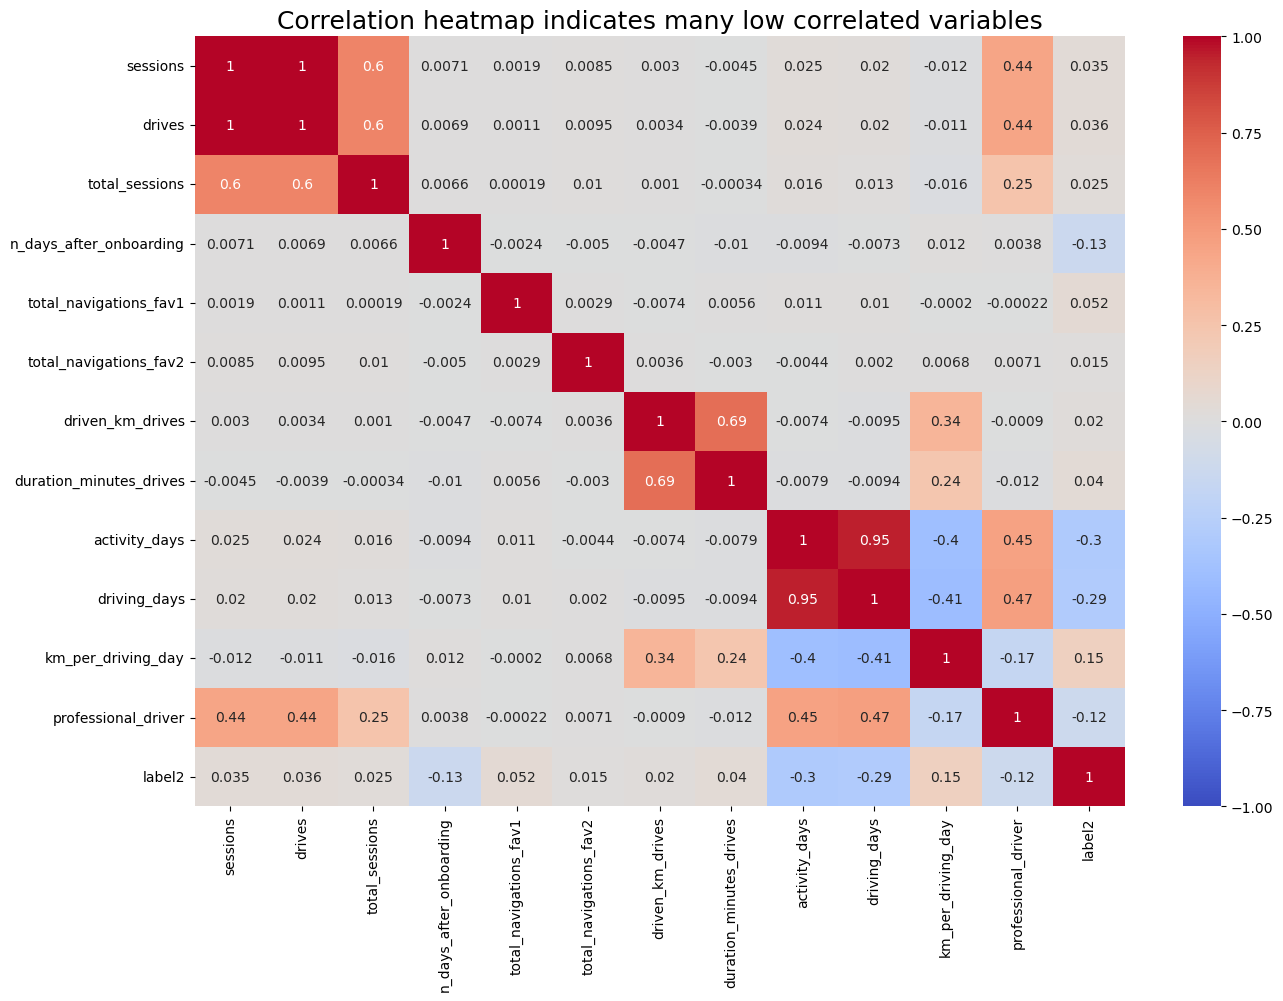

In [18]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show();

If there are predictor variables that have a Pearson correlation coefficient value greater than the **absolute value of 0.7**, these variables are strongly multicollinear. Therefore, only one of these variables should be used in your model.

**Note:** 0.7 is an arbitrary threshold. Some industries may use 0.6, 0.8, etc.

**Question:** Which variables are multicollinear with each other?

> * *`sessions` and `drives`: 1.0*
<br>
> * *`driving_days` and `activity_days`: 0.95*

### **Create dummies (if necessary)**

If you have selected `device` as an X variable, you will need to create dummy variables since this variable is categorical.

In cases with many categorical variables, you can use pandas built-in [`pd.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), or you can use scikit-learn's [`OneHotEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) function.

**Note:** Variables with many categories should only be dummied if absolutely necessary. Each category will result in a coefficient for your model which can lead to overfitting.

Because this dataset only has one remaining categorical feature (`device`), it's not necessary to use one of these special functions. You can just implement the transformation directly.

Create a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

In [19]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


### **Model building**

#### **Assign predictor variables and target**

To build your model you need to determine what X variables you want to include in your model to predict your target&mdash;`label2`.

Drop the following variables and assign the results to `X`:

* `label` (this is the target)
* `label2` (this is the target)
* `device` (this is the non-binary-encoded categorical variable)
* `sessions` (this had high multicollinearity)
* `driving_days` (this had high multicollinearity)

**Note:** Notice that `sessions` and `driving_days` were selected to be dropped, rather than `drives` and `activity_days`. The reason for this is that the features that were kept for modeling had slightly stronger correlations with the target variable than the features that were dropped.

In [20]:
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

Now, isolate the dependent (target) variable. Assign it to a variable called `y`.

In [21]:
# Isolate target variable
y = df['label2']

#### **Split the data**

Use scikit-learn's [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to perform a train/test split on your data using the X and y variables you assigned above.

**Note 1:** It is important to do a train test to obtain accurate predictions.  You always want to fit your model on your training set and evaluate your model on your test set to avoid data leakage.

**Note 2:** Because the target class is imbalanced (82% retained vs. 18% churned), you want to make sure that you don't get an unlucky split that over- or under-represents the frequency of the minority class. Set the function's `stratify` parameter to `y` to ensure that the minority class appears in both train and test sets in the same proportion that it does in the overall dataset.

In [22]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [23]:
# Use .head()
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
152,108,186.192746,3116,243,124,8898.716275,4668.180092,24,612.305861,1,1
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0,1
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0,0
669,108,455.439492,2320,11,4,6566.424830,4558.459870,18,410.401552,1,1
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0,1


Use scikit-learn to instantiate a logistic regression model. Add the argument `penalty = None`.

It is important to add `penalty = 'none'` since your predictors are unscaled.

Fit the model on `X_train` and `y_train`.

In [24]:
model = LogisticRegression(penalty='none', max_iter=400)

model.fit(X_train, y_train)


c:\Users\dmqui\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(max_iter=400, penalty='none')

Call the `.coef_` attribute on the model to get the coefficients of each variable.  The coefficients are in order of how the variables are listed in the dataset.  Remember that the coefficients represent the change in the **log odds** of the target variable for **every one unit increase in X**.

If you want, create a series whose index is the column names and whose values are the coefficients in `model.coef_`.

In [25]:
pd.Series(model.coef_[0], index=X.columns)

drives                     0.001913
total_sessions             0.000327
n_days_after_onboarding   -0.000406
total_navigations_fav1     0.001232
total_navigations_fav2     0.000931
driven_km_drives          -0.000015
duration_minutes_drives    0.000109
activity_days             -0.106032
km_per_driving_day         0.000018
professional_driver       -0.001529
device2                   -0.001041
dtype: float64

In [26]:
model.intercept_

array([-0.00170675])

#### **Check final assumption**

Verify the linear relationship between X and the estimated log odds (known as logits) by making a regplot.

Call the model's `predict_proba()` method to generate the probability of response for each sample in the training data. (The training data is the argument to the method.) Assign the result to a variable called `training_probabilities`. This results in a 2-D array where each row represents a user in `X_train`. The first column is the probability of the user not churning, and the second column is the probability of the user churning.

In [27]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93963485, 0.06036515],
       [0.61967302, 0.38032698],
       [0.76463178, 0.23536822],
       ...,
       [0.9190964 , 0.0809036 ],
       [0.85092114, 0.14907886],
       [0.93516292, 0.06483708]])

In logistic regression, the relationship between a predictor variable and the dependent variable does not need to be linear, however, the log-odds (a.k.a., logit) of the dependent variable with respect to the predictor variable should be linear. Here is the formula for calculating log-odds, where _p_ is the probability of response:
<br>
$$
logit(p) = ln(\frac{p}{1-p})
$$
<br>

1. Create a dataframe called `logit_data` that is a copy of `df`.

2. Create a new column called `logit` in the `logit_data` dataframe. The data in this column should represent the logit for each user.


In [28]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

Plot a regplot where the x-axis represents an independent variable and the y-axis represents the log-odds of the predicted probabilities.

In an exhaustive analysis, this would be plotted for each continuous or discrete predictor variable. Here we show only `driving_days`.

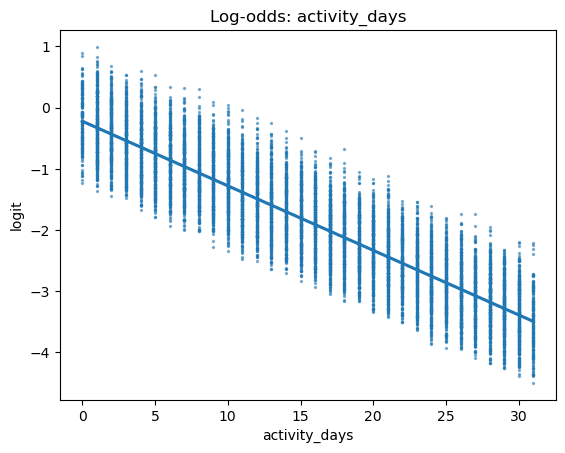

In [29]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

### **Results and evaluation**

If the logistic assumptions are met, the model results can be appropriately interpreted.




In [30]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

Now, use the `score()` method on the model with `X_test` and `y_test` as its two arguments. The default score in scikit-learn is **accuracy**.  What is the accuracy of your model?

*Consider:  Is accuracy the best metric to use to evaluate this model?*

In [31]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.8237762237762237

Use the `confusion_matrix` function to obtain a confusion matrix. Use `y_test` and `y_preds` as arguments.

In [32]:
cm = confusion_matrix(y_test, y_preds)

Next, use the `ConfusionMatrixDisplay()` function to display the confusion matrix from the above cell, passing the confusion matrix you just created as its argument.

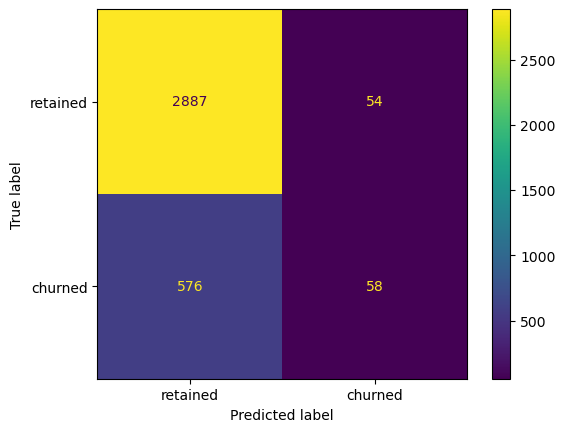

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

In [34]:
# Calculate precision manually
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])
precision

0.5178571428571429

In [35]:
# Calculate recall manually
recall = cm[1,1] / (cm[1, 0] + cm[1, 1])
recall

0.0914826498422713

In [36]:
# Create a classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



**Note:** The model has mediocre precision and very low recall, which means that it makes a lot of false negative predictions and fails to capture users who will churn.

### **Conclusion**

Now that you've built your regression model, the next step is to share your findings with the Waze leadership team. Consider the following questions as you prepare to write your executive summary. Think about key points you may want to share with the team, and what information is most relevant to the user churn project.

**Questions:**


1. What variable most influenced the model's prediction? How? Was this surprising?

> _`activity_days` was by far the most important feature in the model. It had a negative correlation with user churn. This was not surprising, as this variable was very strongly correlated with `driving_days`, which was known from EDA to have a negative correlation with churn._

2. Were there any variables that you expected to be stronger predictors than they were?

> _Yes. In previous EDA, user churn rate increased as the values in `km_per_driving_day` increased. The correlation heatmap here in this notebook revealed this variable to have the strongest positive correlation with churn of any of the predictor variables by a relatively large margin. In the model, it was the second-least-important variable._

3. Why might a variable you thought to be important not be important in the model?

> _In a multiple logistic regression model, features can interact with each other and these interactions can result in seemingly counterintuitive relationships. This is both a strength and a weakness of predictive models, as capturing these interactions typically makes a model more predictive while at the same time making the model more difficult to explain._

4. Would you recommend that Waze use this model? Why or why not?

> _It depends. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value._

5. What could you do to improve this model?

> _New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, one of the engineered features (`professional_driver`) was the third-most-predictive predictor. It could also be helpful to scale the predictor variables, and/or to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._

6. What additional features would you like to have to help improve the model?

> _It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._